## 1. Meet Professor William Sharpe
<p>An investment may make sense if we expect it to return more money than it costs. But returns are only part of the story because they are risky - there may be a range of possible outcomes. How does one compare different investments that may deliver similar results on average, but exhibit different levels of risks?</p>
<p><img style="float: left ; margin: 5px 20px 5px 1px;" width="200" src="https://assets.datacamp.com/production/project_66/img/sharpe.jpeg"></p>
<p>Enter William Sharpe. He introduced the <a href="https://web.stanford.edu/~wfsharpe/art/sr/sr.htm"><em>reward-to-variability ratio</em></a> in 1966 that soon came to be called the Sharpe Ratio. It compares the expected returns for two investment opportunities and calculates the additional return per unit of risk an investor could obtain by choosing one over the other. In particular, it looks at the difference in returns for two investments and compares the average difference to the standard deviation (as a measure of risk) of this difference. A higher Sharpe ratio means that the reward will be higher for a given amount of risk. It is common to compare a specific opportunity against a benchmark that represents an entire category of investments.</p>
<p>The Sharpe ratio has been one of the most popular risk/return measures in finance, not least because it's so simple to use. It also helped that Professor Sharpe won a Nobel Memorial Prize in Economics in 1990 for his work on the capital asset pricing model (CAPM).</p>
<p>The Sharpe ratio is usually calculated for a portfolio and uses the risk-free interest rate as benchmark. We will simplify our example and use stocks instead of a portfolio. We will also use a stock index as benchmark rather than the risk-free interest rate because both are readily available at daily frequencies and we do not have to get into converting interest rates from annual to daily frequency. Just keep in mind that you would run the same calculation with portfolio returns and your risk-free rate of choice, e.g, the <a href="https://fred.stlouisfed.org/series/TB3MS">3-month Treasury Bill Rate</a>. </p>
<p>So let's learn about the Sharpe ratio by calculating it for the stocks of the two tech giants Facebook and Amazon. As benchmark we'll use the S&amp;P 500 that measures the performance of the 500 largest stocks in the US. When we use a stock index instead of the risk-free rate, the result is called the Information Ratio and is used to benchmark the return on active portfolio management because it tells you how much more return for a given unit of risk your portfolio manager earned relative to just putting your money into a low-cost index fund.</p>

In [84]:
# Importing required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Settings to produce nice plots in a Jupyter notebook
plt.style.use('fivethirtyeight')
%matplotlib inline

# Reading in the data
stock_data = pd.read_csv('datasets/stock_data.csv', parse_dates = ['Date'], index_col = 'Date').dropna()
benchmark_data = pd.read_csv('datasets/benchmark_data.csv', parse_dates = ['Date'], index_col = 'Date').dropna()

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


## 2. A first glance at the data
<p>Let's take a look the data to find out how many observations and variables we have at our disposal.</p>

In [86]:
# Display summary for stock_data
print('Stocks\n')
stock_data.info()

# Display summary for benchmark_data
print('\nBenchmarks\n')
benchmark_data.info()


Stocks

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2016-01-04 to 2016-12-30
Data columns (total 2 columns):
Amazon      252 non-null float64
Facebook    252 non-null float64
dtypes: float64(2)
memory usage: 5.9 KB

Benchmarks

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2016-01-04 to 2016-12-30
Data columns (total 1 columns):
S&P 500    252 non-null float64
dtypes: float64(1)
memory usage: 3.9 KB


## 3. Plot & summarize daily prices for Amazon and Facebook
<p>Before we compare an investment in either Facebook or Amazon with the index of the 500 largest companies in the US, let's visualize the data, so we better understand what we're dealing with.</p>

,Amazon,Facebook
count,252.000000,252.000000
mean,699.523135,117.035873
std,92.362312,8.899858
min,482.070007,94.160004
25%,606.929993,112.202499
50%,727.875000,117.765000
75%,767.882492,123.902503
max,844.359985,133.279999


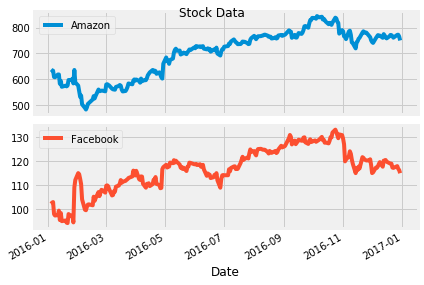

In [88]:
# visualize the stock_data
plt = stock_data.plot(title = 'Stock Data', subplots = True)


# summarize the stock_data
stock_data.describe()


## 4. Visualize & summarize daily values for the S&P 500
<p>Let's also take a closer look at the value of the S&amp;P 500, our benchmark.</p>

,S&P 500
count,252.000000
mean,2094.651310
std,101.427615
min,1829.080000
25%,2047.060000
50%,2104.105000
75%,2169.075000
max,2271.720000


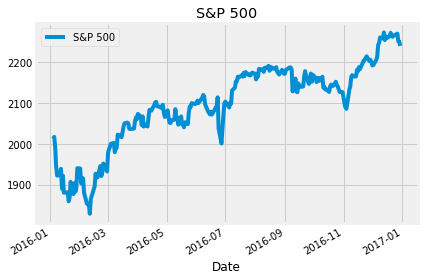

In [90]:
# plot the benchmark_data
benchmark_data.plot(title = 'S&P 500')


# summarize the benchmark_data
benchmark_data.describe()


## 5. The inputs for the Sharpe Ratio: Starting with Daily Stock Returns
<p>The Sharpe Ratio uses the difference in returns between the two investment opportunities under consideration.</p>
<p>However, our data show the historical value of each investment, not the return. To calculate the return, we need to calculate the percentage change in value from one day to the next. We'll also take a look at the summary statistics because these will become our inputs as we calculate the Sharpe Ratio. Can you already guess the result?</p>

,Amazon,Facebook
count,251.000000,251.000000
mean,0.000818,0.000626
std,0.018383,0.017840
min,-0.076100,-0.058105
25%,-0.007211,-0.007220
50%,0.000857,0.000879
75%,0.009224,0.008108
max,0.095664,0.155214


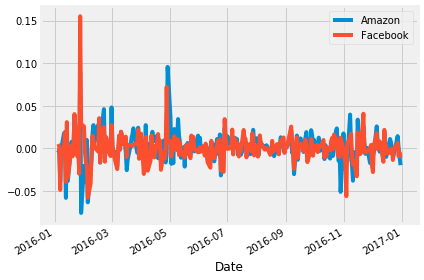

In [92]:
# calculate daily stock_data returns
stock_returns = stock_data.pct_change()

# plot the daily returns
stock_returns.plot();

# summarize the daily returns
stock_returns.describe()

## 6. Daily S&P 500 returns
<p>For the S&amp;P 500, calculating daily returns works just the same way, we just need to make sure we select it as a <code>Series</code> using single brackets <code>[]</code> and not as a <code>DataFrame</code> to facilitate the calculations in the next step.</p>

count    251.000000
mean       0.000458
std        0.008205
min       -0.035920
25%       -0.002949
50%        0.000205
75%        0.004497
max        0.024760
Name: S&P 500, dtype: float64

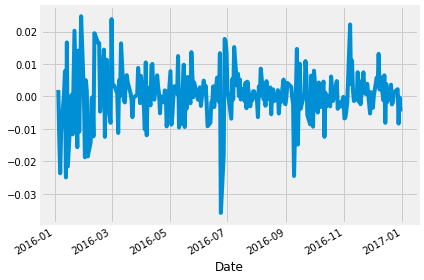

In [94]:
# calculate daily benchmark_data returns
sp_returns = benchmark_data['S&P 500'].pct_change()

# plot the daily returns
sp_returns.plot()


# summarize the daily returns
sp_returns.describe()


## 7. Calculating Excess Returns for Amazon and Facebook vs. S&P 500
<p>Next, we need to calculate the relative performance of stocks vs. the S&amp;P 500 benchmark. This is calculated as the difference in returns between <code>stock_returns</code> and <code>sp_returns</code> for each day.</p>

,Amazon,Facebook
count,251.000000,251.000000
mean,0.000360,0.000168
std,0.016126,0.015439
min,-0.100860,-0.051958
25%,-0.006229,-0.005663
50%,0.000698,-0.000454
75%,0.007351,0.005814
max,0.100728,0.149686


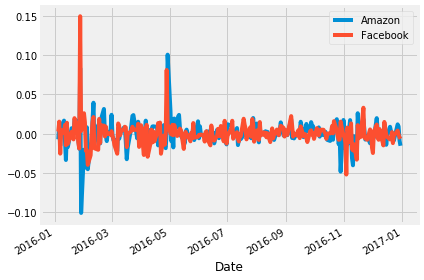

In [96]:
# calculate the difference in daily returns
excess_returns = stock_returns.sub(sp_returns, axis = 0)

# plot the excess_returns
excess_returns.plot()


# summarize the excess_returns
excess_returns.describe()


## 8. The Sharpe Ratio, Step 1: The Average Difference in Daily Returns Stocks vs S&P 500
<p>Now we can finally start computing the Sharpe Ratio. First we need to calculate the average of the <code>excess_returns</code>. This tells us how much more or less the investment yields per day compared to the benchmark.</p>

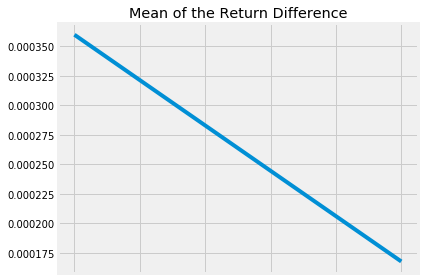

In [98]:
# calculate the mean of excess_returns 
avg_excess_return = excess_returns.mean()

# plot avg_excess_returns
avg_excess_return.plot(title = 'Mean of the Return Difference')


## 9. The Sharpe Ratio, Step 2: Standard Deviation of the Return Difference
<p>It looks like there was quite a bit of a difference between average daily returns for Amazon and Facebook.</p>
<p>Next, we calculate the standard deviation of the <code>excess_returns</code>. This shows us the amount of risk an investment in the stocks implies as compared to an investment in the S&amp;P 500.</p>

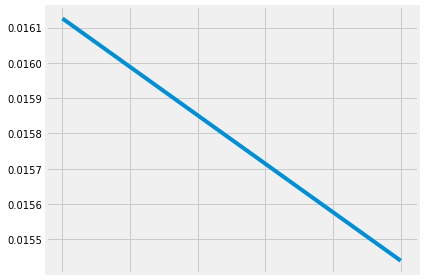

In [100]:
# calculate the standard deviations
sd_excess_return = excess_returns.std()

# plot the standard deviations
sd_excess_return.plot()


## 10. Putting it all together
<p>Now we just need to compute the ratio of <code>avg_excess_returns</code> and <code>sd_excess_returns</code>. The result is now finally the <em>Sharpe ratio</em> and indicates how much more (or less) return the investment opportunity under consideration yields per unit of risk.</p>
<p>The Sharpe Ratio is often <em>annualized</em> by multiplying it by the square root of the number of periods. We have used daily data as input, so we'll use the square root of the number of trading days (5 days, 52 weeks, minus a few holidays): √252</p>

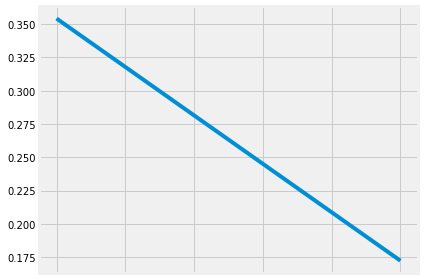

In [102]:
# calculate the daily sharpe ratio
daily_sharpe_ratio = avg_excess_return / sd_excess_return

# annualize the sharpe ratio
annual_factor = 252 ** 0.5
annual_sharpe_ratio = daily_sharpe_ratio * annual_factor

# plot the annualized sharpe ratio
annual_sharpe_ratio.plot()


## 11. Conclusion
<p>Given the two Sharpe ratios, which investment should we go for? In 2016, Amazon had a Sharpe ratio twice as high as Facebook. This means that an investment in Amazon returned twice as much compared to the S&amp;P 500 for each unit of risk an investor would have assumed. In other words, in risk-adjusted terms, the investment in Amazon would have been more attractive.</p>
<p>This difference was mostly driven by differences in return rather than risk between Amazon and Facebook. The risk of choosing Amazon over FB (as measured by the standard deviation) was only slightly higher so that the higher Sharpe ratio for Amazon ends up higher mainly due to the higher average daily returns for Amazon. </p>
<p>When faced with investment alternatives that offer both different returns and risks, the Sharpe Ratio helps to make a decision by adjusting the returns by the differences in risk and allows an investor to compare investment opportunities on equal terms, that is, on an 'apples-to-apples' basis.</p>

In [104]:
buy_amazon = True